# Constitutional AI

Wir möchten, dass die Ausgabe von unserem Agenten sich immer an bestimmte Richtlinien hält.
Wir können ein LLM als Revisor dahinter schalten. Das Revisor-LLM kennt die Richtlinien kennt und zwingt den Agenten dazu, bei einer Verletzung der Richtlinien die Ausgabe neu zu generieren.


In [1]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)

generator_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            """You are a helpful assistant. Answer this question as good as you can. You are being revised.
            If you are being revised, just reformulate your original answer. Original Question:"""
        ),
        HumanMessagePromptTemplate.from_template("{query}"),
        MessagesPlaceholder("revision_dialogue"),
        SystemMessagePromptTemplate.from_template(
            "If the revisor asked you to reformulate your answer, please do so. Do NOT apologize. JUST REFORMULATE."
        ),
    ]
)

revisor_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            """You are a Revisor. You are revising the answer of a chatbot. Your principles are as follows:
                {principles}
                You can either return the answer from the chatbot to the user or tell the chatbot to reformulate his answer if any principles are violated.
                Original Question:"""
        ),
        HumanMessagePromptTemplate.from_template("{query}"),
        MessagesPlaceholder("revision_dialogue"),
    ]
)

In [2]:
import operator
from typing import Annotated, Optional, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    query: str
    principles: str
    revision_dialogue: Annotated[Sequence[BaseMessage], operator.add]
    answer: Optional[str]

In [17]:
from helpers import llm

model = llm(model="gpt-4o-mini", temperature=0.7)

In [18]:
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import END


def generator(state):
    generator_chain = generator_prompt | model

    proposal = generator_chain.invoke(
        {"query": state["query"], "revision_dialogue": state["revision_dialogue"] or []}
    )

    return {"revision_dialogue": [proposal]}


def revisor(state):
    class Revision(BaseModel):
        acceptable: str = Field(
            description="Is the answer of the chatbot compliant with the principles? answer is 'yes' or 'no'"
        )
        critique: Optional[str] = Field(
            description="Critique of the document. Leave out if answer is acceptable.",
            default=None,
        )

    revisor_model = model.with_structured_output(Revision)

    revisor_chain = revisor_prompt | revisor_model

    revision: Revision = revisor_chain.invoke(
        {
            "query": state["query"],
            "revision_dialogue": state["revision_dialogue"],
            "principles": state["principles"],
        }
    )

    accepted = revision.acceptable == "yes" and revision.critique is None

    if accepted:
        return {"answer": state["revision_dialogue"][-1].content}
    else:
        return {"revision_dialogue": [HumanMessage(content=revision.critique)]}


def is_accepted(state):
    if state.get("answer", None):
        return END
    else:
        return "generator"

In [19]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("generator", generator)
workflow.add_node("revisor", revisor)
workflow.set_entry_point("generator")
workflow.add_edge("generator", "revisor")
workflow.add_conditional_edges("revisor", is_accepted)

app = workflow.compile()

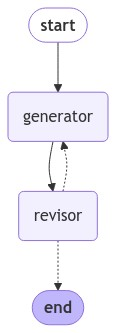

In [6]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [23]:
inputs = {
    "query": "Tell me a joke about star trek (or any other sci-fi series).",
    "principles": "The joke must not reference any star trek specific characters or events.",
}

In [24]:
for chunk in app.stream(input=inputs):
    for k, v in chunk.items():
        print(f"answer from node: {k}")
        print(v)
        if k == "__end__":
            print("\n--- Final answer ---\n")
            print(v["answer"])

answer from node: generator
{'revision_dialogue': [AIMessage(content='Why did the Borg go to therapy? \n\nBecause they had trouble with personal connections!', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1'}, id='run-ae7a169a-a17e-48ea-acaf-11ec295f1371-0')]}
answer from node: revisor
{'revision_dialogue': [HumanMessage(content='The joke references the Borg, a specific group from Star Trek, which violates the principle of not referencing any Star Trek specific characters or events.')]}
answer from node: generator
{'revision_dialogue': [AIMessage(content='Why did the spaceship get a promotion? \n\nBecause it always knew how to take off and reach new heights!', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1'}, id='run-47064fda-5d1a-4714-a399-782caf93d870-0')]}
answer from node: revisor
{'revision_dialogue': [HumanMessage(content='The joke re